In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from scipy.optimize import linear_sum_assignment

# plt.rcparams222['image.cmap'] = 'gray'

show_all = True

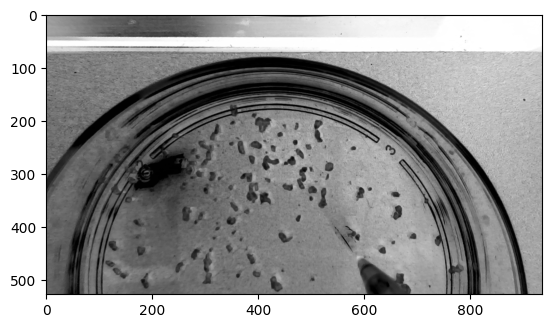

In [6]:
number_before = 0
number_after = 5
images_before = []
images_before_gray = []
images_after = []
images_after_gray = []

for i in range(5):
    images_before.append(cv2.cvtColor(cv2.imread(r'C:\Users\APrap\Documents\CREATE\Pick-and-Place\Pictures\detection/image_check' + str(number_before+i)+'.png'), cv2.COLOR_BGR2RGB))
    images_before_gray.append(255 - cv2.cvtColor(cv2.imread(r'C:\Users\APrap\Documents\CREATE\Pick-and-Place\Pictures\detection/image_check' + str(number_after+i)+'.png'), cv2.COLOR_BGR2GRAY))
    images_after.append(cv2.cvtColor(cv2.imread(r'C:\Users\APrap\Documents\CREATE\Pick-and-Place\Pictures\detection/image_check' + str(number_after+i)+'.png'), cv2.COLOR_BGR2RGB))
    images_after_gray.append(255 - cv2.cvtColor(cv2.imread(r'C:\Users\APrap\Documents\CREATE\Pick-and-Place\Pictures\detection/image_check' + str(number_after+i)+'.png'), cv2.COLOR_BGR2GRAY))

if show_all:
    plt.imshow(images_before_gray[2], cmap='gray')

In [2]:
def distance(p1, p2):
    """Compute the Euclidean distance between two points."""
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def find_optimum(points1, points2):
    """Find the best combination of pairs to link all points in points1 to all points in points2."""
    n = len(points1)
    m = len(points2)
    cost = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            cost[i, j] = distance(points1[i], points2[j])
    row_ind, col_ind = linear_sum_assignment(cost)
    pairs = []
    for i, j in zip(row_ind, col_ind):
        pairs.append((points1[i], points2[j]))
    return pairs

In [7]:
points1 = [(0,0), (1,1), (2,2)]
points2 = [(3,3), (4,4), (5,5)]

pairs = find_optimum(points1, points2)
print(pairs)

[((0, 0), (3, 3)), ((1, 1), (4, 4)), ((2, 2), (5, 5))]
